# 机器学习建模流程

建模流程可以分解如下:

1. 建模问题分析
2. 数据分析
3. 数据处理
4. 特征工程
5. 训练、验证、测试数据划分
6. 模型训练
7. 模型验证
8. 模型预测

我们将选用[Kaggle房价预测](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data)为例，使用`numpy`, `pandas`, `matplotlib`, `sklearn` 库，参照指引搭建一个最简化的线性回归模型，来掌握建模流程。

## 1. 建模问题分析

仔细阅读[竞赛背景](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview)中问题描述及评价指标，该竞赛属于典型`回归预测`，采用了`对数化RMSE`评价指标，因此我们考虑正常使用线性回归模型，并在本地实现RMSE评价函数。

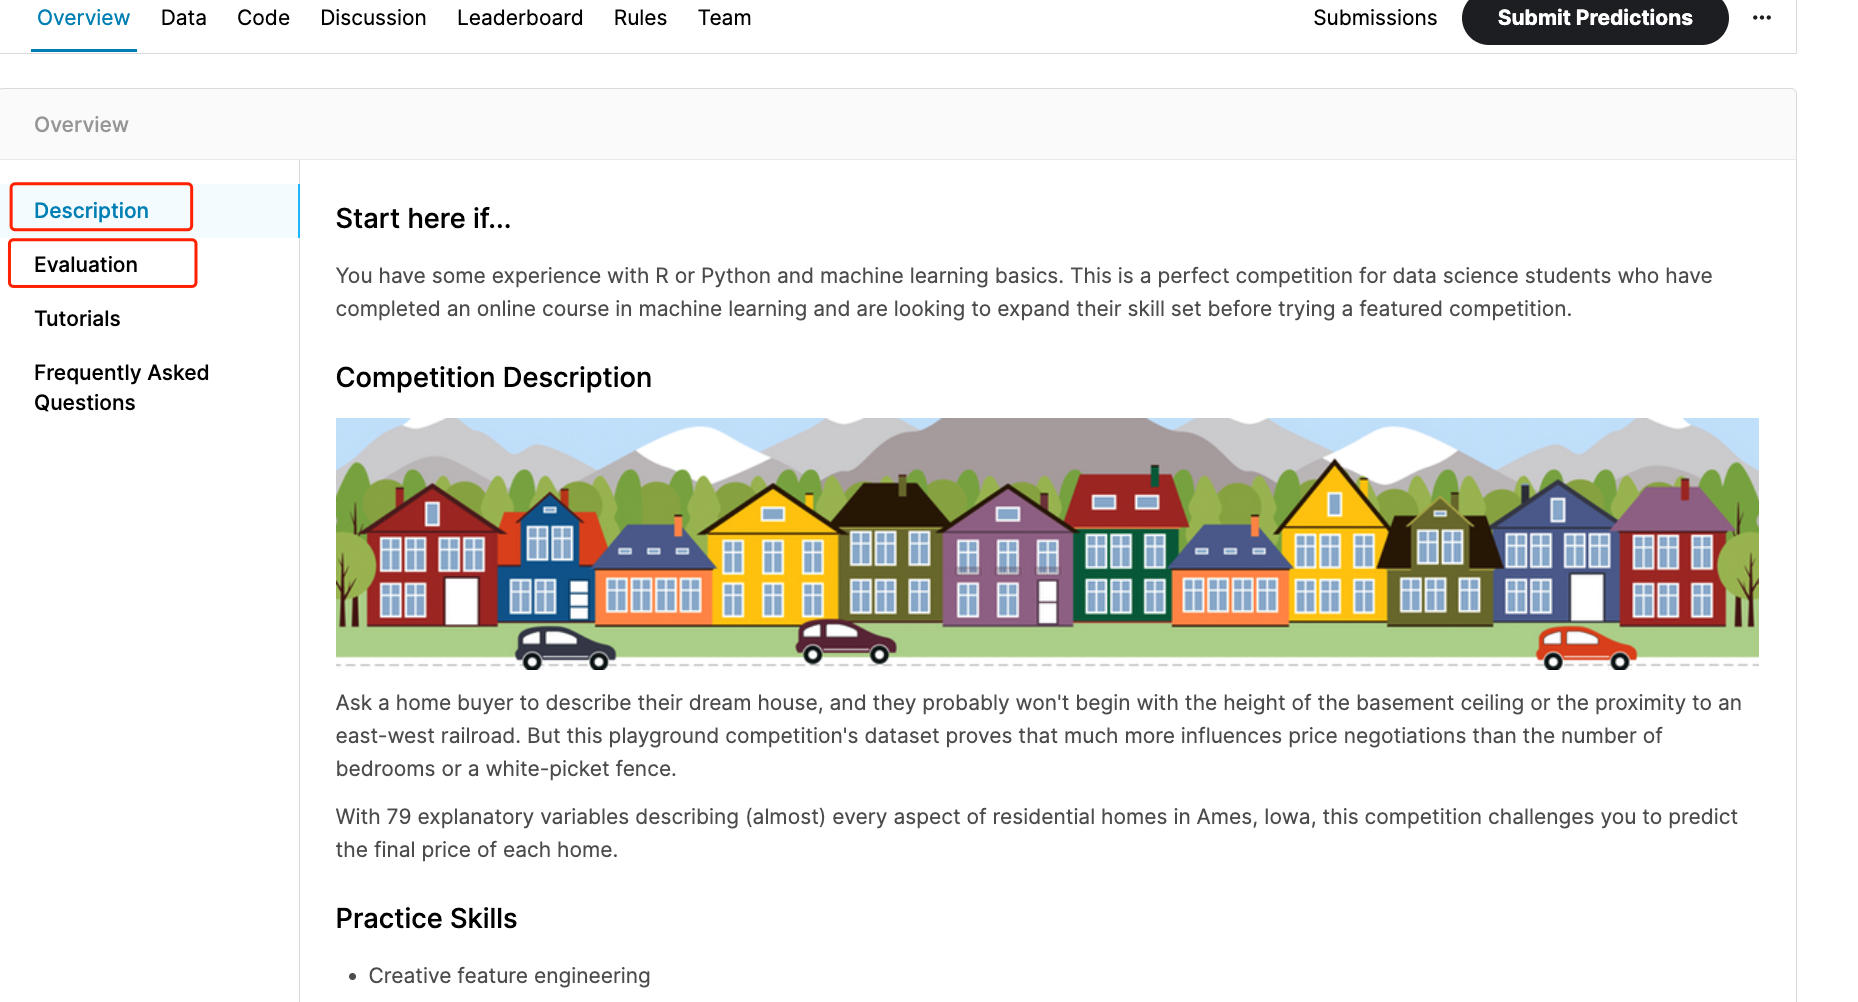

In [1]:
import numpy as np

def rmse_score(y_true, y_pred):
    return np.sqrt(np.mean((np.log(y_true) - np.log(y_pred)) ** 2))

## 2. 数据分析

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train = pd.read_csv("./train.csv")# 注意需下载对应数据放到根目录下
test = pd.read_csv("./test.csv")

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# 样本数量
print(train.shape, test.shape)

(1460, 81) (1459, 80)


In [5]:
# 非数值型特征43个，整数特征35个(包含Id)，浮点数值特征2个，预测目标1个
train.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

## 3. 数据处理

In [6]:
# 提取标签

train_label = train['SalePrice'].values
del train['SalePrice']

In [7]:
# 这里只演示基本流程，为了方案舍弃所有非数值数据
# Id列没有任何实际含义，舍弃
use_cols = train.drop('Id', axis=1).dtypes[train.dtypes != 'object'].index.tolist()

print(use_cols)

train = train[use_cols]
test = test[use_cols]

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [8]:
# 查看存在缺失的特征

train.columns[train.isnull().sum() > 0]

Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object')

In [9]:
test.columns[test.isnull().sum() > 0]

Index(['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt',
       'GarageCars', 'GarageArea'],
      dtype='object')

In [10]:
# 训练集中'LotFrontage', 'MasVnrArea', 'GarageYrBlt' 存在缺失
# 在https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data 中查看数据字段含义
# 分析3列缺失数据应该选用的数据补全方案
# 1. LotFrontage Linear feet of street connected to property 房屋临街正面面积
# 2. MasVnrArea 贴面区域面积
# 3. GarageYrBlt 车库修建年份
# 均可以选用平均值或中位数进行填充 (思考两者有什么区别)

In [11]:
train.loc[:, ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']] = \
train[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']].fillna(train[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']].median())

In [12]:
# 测试集中缺失数据依然需要进行分析，这里简单采用中位数进行填充

In [13]:
test = test.fillna(test.median())

## 4. 特征工程

为简化流程，这里不进行任何特征工程实现，但可以思考:
- 建筑时间是否转化为建筑年龄(当前时间 - 修建时间)更加合理?

- 当我们采用线性回归进行建模，但某特征，比如建筑年龄与房价不是线性关系，可以如何处理?(分箱离散化+onehot等)

-  ...

## 5. 训练、验证、测试数据划分

比赛已经帮我们划分了测试数据，因此我们只需要在训练数据上划分一个验证集，用于调参过程的模型性能评估。

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
train, valid, train_label, valid_label = train_test_split(train, train_label, test_size=0.33, random_state=42)

## 6. 模型训练

In [16]:
from sklearn.linear_model import LinearRegression, Ridge

In [17]:
# 这里我们对比一下普通的线性回归模型和 L2正则化线性模型Ridge

lr = LinearRegression()
ridge = Ridge()

In [18]:
lr.fit(train, train_label)
ridge.fit(train, train_label)

Ridge()

## 7. 模型评估

In [19]:
lr_valid_pred = lr.predict(valid)
ridge_valid_pred = ridge.predict(valid)

In [20]:
rmse_score(valid_label, lr_valid_pred)

0.19396497724197337

In [21]:
rmse_score(valid_label, ridge_valid_pred)

0.19388995943585613

## 8. 模型预测

In [22]:
ridge_test_pred = ridge.predict(test)

In [24]:
# 按照格式要求准备提交数据

submission = pd.read_csv("./sample_submission.csv")
submission['SalePrice'] = ridge_test_pred
submission.to_csv("submission.csv", index=False)

## 作业

1. 参照流程，全程自己的建模代码，在Kaggle提交模型预测结果.
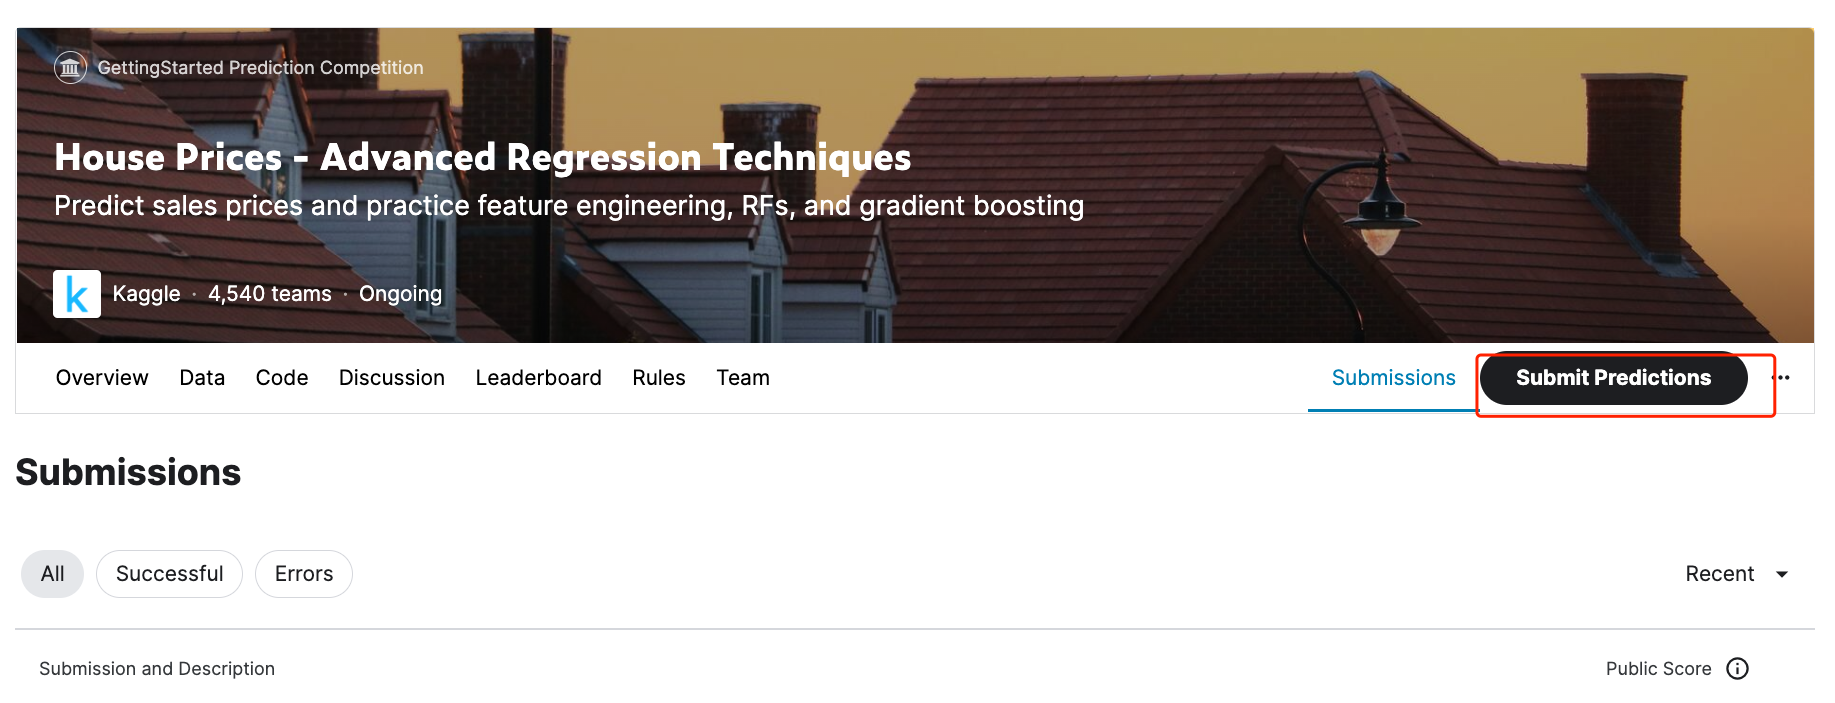

2. 分析数据，尝试构造特征，得到更好的建模效果。